<a href="https://colab.research.google.com/github/b0ws3r/EOSC510_Final/blob/main/EOSC510_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import csv
import uuid
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import matplotlib
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from pandas import DataFrame
import datetime


Mounted at /content/drive


## Definitions

In [ ]:

wdir = '/content/drive/MyDrive/Colab Notebooks/EOSC510_Final'
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [ ]:
def filter_on_date(df, year, month, day):
      df_filtered = df
      if "Date" in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        date_filter = df["Date"] == pd.Timestamp(year, month, day)
        df_filtered = df[date_filter]
      else:
        print("No date column available to filter on")
      return df_filtered

In [ ]:
# we get output y_hats for 1 date. need to compare them to orig
def join_data_to_original(predictions, original_all_columns, date_filter=None, ):
  df_new = original_all_columns.copy()

  print(predictions.columns)
  ind = predictions.columns.shape[0]
  print(ind)
  df_new["pred_tmin"] = predictions["pred_tmin"].iloc[:].values
  df_new["pred_tmax"] = predictions["pred_tmax"].iloc[:].values

  print(df_new.head(3))
  return df_new

In [ ]:
def get_predictions_from_best_performer(input_data):
  best_performer = "/content/drive/MyDrive/Colab Notebooks/EOSC510_Final/2b1fe551-20b7-45c2-911e-338208fcdd15.p"
  loaded_models = pickle.load(open(best_performer,"rb"))
  print(best_performer)
  all_tmins =[]
  all_tmaxs = []
  for mod in loaded_models:
    pred_output = mod.predict(input_data)
    output_rows = pred_output.shape[0]
    tmins = pred_output[:,0]
    tmaxs = pred_output[:,1]
    all_tmins.append(tmins)
    all_tmaxs.append(tmaxs)

  # get ensemble mean for each variable
  all_tmins = np.asarray(all_tmins)
  tmin_mean_predicted_output = all_tmins.mean(axis=0)
  all_tmaxs = np.asarray(all_tmaxs)
  tmax_mean_predicted_output = all_tmaxs.mean(axis=0)

  data = {"pred_tmin": tmin_mean_predicted_output, "pred_tmax": tmax_mean_predicted_output}
  predictions_df = pd.DataFrame(data)
  print(predictions_df.head(3))
  return predictions_df


## Data prep

In [ ]:
### Data
df = pd.read_pickle(f"{wdir}/prism_gfs_all_columns_result.p")

# X  = df.iloc[:, 0:2]
# Y = df['y']


# training is data pts b/w 48 and 48.5 deg north
# split X into training and validation datasets (50% train, 25% validation, 25% test)
trn_filter = df["Latitude"].astype(float) < (48.5)


val_filter_S = df["Latitude"] >= 48.5
val_filter_N = df["Latitude"] < 48.75

tst_filter_S = df["Latitude"] >= 48.75
tst_filter_N = df["Latitude"] <= 49

# set training
train = df[trn_filter]
# save training data
pickle.dump(train,open(f"{wdir}/train_all_columns.p","wb"))
x_train = train[["Latitude", "Longitude","us", "gfs_tmin", "gfs_tmax"]]
y_train = train[["tmin_K", "tmax_K"]]

# validation is what we don't pick for training
val = df[val_filter_N]
val = val[val_filter_S]
validation_date =pd.Timestamp(2023, 4, 15) # because why not
val['Date'] = pd.to_datetime(val['Date'])
date_filter = val["Date"] == validation_date
val = val[date_filter]
pickle.dump(val,open(f"{wdir}/val_all_columns.p","wb"))

# get rid of date col
x_val = val[["Latitude", "Longitude","us", "gfs_tmin", "gfs_tmax"]]
y_val = val[["tmin_K", "tmax_K", "Date"]]
y_val = y_val[date_filter]
y_val = y_val[["tmin_K", "tmax_K", ]]


# testing ---> don't touch until very end!!! OR ELSE
# tst = df[tst_filter]
test = df[tst_filter_N]
test = test[tst_filter_S]
validation_date =pd.Timestamp(2023, 4, 15) # because why not
test['Date'] = pd.to_datetime(test['Date'])
date_filter = test["Date"] == validation_date
test = test[date_filter]
pickle.dump(test,open(f"{wdir}/tst_all_columns.p","wb"))

# get rid of date col
x_tst = test[["Latitude", "Longitude","us", "gfs_tmin", "gfs_tmax"]]
y_tst = test[["tmin_K", "tmax_K", "Date"]]
y_tst = y_tst[date_filter]
y_tst = y_tst[["tmin_K", "tmax_K", ]]


## all data for visual

all = df
validation_date =pd.Timestamp(2023, 4, 15) # because why not
all['Date'] = pd.to_datetime(all['Date'])
date_filter = all["Date"] == validation_date
all = all[date_filter]
pickle.dump(all,open(f"{wdir}/all_all_columns.p","wb"))

# get rid of date col
x_all = all[["Latitude", "Longitude","us", "gfs_tmin", "gfs_tmax"]]
y_all = all[["tmin_K", "tmax_K", "Date"]]
y_all = all[date_filter]
y_all = all[["tmin_K", "tmax_K", ]]



# standardize
vars = ["gfs_tmin", "gfs_tmax", "us"]
for var in vars:
  x_mean =x_train[var].mean()
  x_std = np.std(x_train[var])

  x_train[var] = (x_train[var] - x_mean) / x_std
  x_val[var] = (x_val[var] - x_mean) / x_std
  x_tst[var] = (x_tst[var] - x_mean) / x_std
  x_all[var] = (x_all[var] - x_mean) / x_std


y_vars = ["tmin_K", "tmax_K"]
for var in y_vars:
  y_mean =y_train[var].mean()
  y_std = np.std(y_train[var])
  y_train[var] = (y_train[var] - y_mean) / y_std
  y_val[var] = (y_val[var] - y_mean) / y_std
  y_tst[var] = (y_tst[var] - y_mean) / y_std
  y_all[var] = (y_all[var] - y_mean) / y_std


print(x_train.head(3))
print(y_train.head(3))

print(x_val.head(3))
print(y_val.head(3))

print(x_tst.head(3))
print(y_tst.head(3))

print(x_all.head(3))
print(y_all.head(3))



<ipython-input-6-a7653b24b4a4>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val = val[val_filter_S]
<ipython-input-6-a7653b24b4a4>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_val = y_val[date_filter]
<ipython-input-6-a7653b24b4a4>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_tst = y_tst[date_filter]


       Latitude  Longitude        us  gfs_tmin  gfs_tmax
19452     48.46    -122.00 -0.804903  0.002023 -0.491285
19453     48.46    -121.96 -0.030734  0.002023 -0.491285
19454     48.46    -121.92  0.070596  0.002023 -0.491285
         tmin_K    tmax_K
19452 -0.452919 -0.574183
19453 -0.858101 -0.952229
19454 -0.914989 -0.998968
      Latitude  Longitude        us  gfs_tmin  gfs_tmax
6608     48.71    -122.00  0.903537  0.495339   -0.1041
6609     48.71    -121.96  0.536719  0.495339   -0.1041
6610     48.71    -121.92  0.194220  0.495339   -0.1041
        tmin_K    tmax_K
6608 -0.989336 -0.924240
6609 -0.772210 -0.559578
6610 -0.610965 -0.219740
     Latitude  Longitude        us  gfs_tmin  gfs_tmax
209     48.96    -122.00 -0.144225  0.685951   0.29605
210     48.96    -121.96  0.206380  0.685951   0.29605
211     48.96    -121.92 -0.048974  0.685951   0.29605
       tmin_K    tmax_K
209 -0.325715 -0.297217
210 -0.502490 -0.504500
211 -0.438111 -0.263990
     Latitude  Longitude    

<ipython-input-6-a7653b24b4a4>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_all = all[date_filter]
<ipython-input-6-a7653b24b4a4>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[var] = (x_train[var] - x_mean) / x_std
<ipython-input-6-a7653b24b4a4>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val[var] = (x_val[var] - x_mean) / x_std
<ipython-input-6-a7653b24b4a4>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
x_tst.shape

(432, 5)

## MLP with LAT/LON

### Hyperparams

In [ ]:
# Define your hyperparameters and RMSE
hyperparams = {
    'solver': 'adam',
    'activation': 'relu',
    'alpha': 0.01, # L2-reg
    'batch_size': 'auto',
    'learning_rate_init': 0.01,
    'learning_rate': 'adaptive',
    'shuffling': True,
    'validation_fraction': 0.2,
    'num_models': 30,
    'min_nhn': 10,
    'max_nhn': 50,
    'max_hidden_layers': 5,
    'rmse': 0,
    'ensemble_guid': ''
}

In [ ]:
ensemble_guid = uuid.uuid4()
max_iter = 1500 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []
all_models = []    ### NEW

for model_num in range(hyperparams['num_models']): #for each model in the ensemble
    print('Model Number: ' + str(model_num))
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    models = []   ### NEW

    for num_hidden_layers in range(1,hyperparams['max_hidden_layers']+1):
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
        for num_hidden_neurons in range(hyperparams['min_nhn'],hyperparams['max_nhn']+1): #for each number of hidden neurons
            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))

            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                 verbose=False,
                                 max_iter=max_iter,
                                 early_stopping = early_stopping,
                                 validation_fraction = hyperparams['validation_fraction'],
                                 batch_size =hyperparams['batch_size'],
                                 solver = hyperparams['solver'],
                                 alpha= hyperparams['alpha'], # regularize in order to penalize outliers
                                 # so far .01 reg has lowest RMSE
                                 activation = hyperparams['activation'],
                                 learning_rate_init = hyperparams['learning_rate_init'],
                                 learning_rate = hyperparams['learning_rate'],
                                 shuffle = hyperparams['shuffling'])

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_val) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_val,y_out_this_nhn)) #RMSE between cumulative curves
            print(rmse(y_val,y_out_this_nhn))
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)

            models.append(model) ### NEW

    #index of model with lowest RMSE
    tmin_tmax_total_rmses = np.sum(RMSE, axis=1)
    print(tmin_tmax_total_rmses)
    print(RMSE)
    indBest = tmin_tmax_total_rmses.argmin()#((np.min(tmin_tmax_total_rmses)))
    RMSE_ensemble.append(np.min(tmin_tmax_total_rmses))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])

    all_models.append(models[indBest])
    y_out_ensemble.append(y_out_all_nhn[indBest])
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')


y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean, y_val)
print(f"\tEnsemble: {ensemble_guid} \r\n\t" +
      f"RMSE:{str(RMSE_ensemble_mean)}")
hyperparams['rmse'] = RMSE_ensemble_mean
hyperparams['ensemble_guid'] = ensemble_guid


wdir = '/content/drive/MyDrive/Colab Notebooks/EOSC510_Final'

### Now, we have a list of the best-performing models.
### First thing to do is save them.
### This is really important if you're working with a partner & in the interest of making results repeatable
### and just so you don't have to run the above code all the time
pickle_path = f"{wdir}/{ensemble_guid}.p"
pickle.dump(all_models,open(pickle_path,"wb"))

# Save results to a CSV to track which architecture resulted in lowest RMSE
with open(f"{wdir}/final_mlp_hyperparams_log.csv", 'a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=hyperparams.keys())
    if file.tell() == 0:  # Write header if file is empty
        writer.writeheader()
    writer.writerow(hyperparams)

Streaming output truncated to the last 5000 lines.
tmax_K    0.632216
dtype: float64
		 # hidden neurons = 34
tmin_K    0.982530
tmax_K    0.634109
dtype: float64
		 # hidden neurons = 35
tmin_K    0.971157
tmax_K    0.633191
dtype: float64
		 # hidden neurons = 36
tmin_K    0.981067
tmax_K    0.636719
dtype: float64
		 # hidden neurons = 37
tmin_K    0.976642
tmax_K    0.632709
dtype: float64
		 # hidden neurons = 38
tmin_K    0.967927
tmax_K    0.631474
dtype: float64
		 # hidden neurons = 39
tmin_K    0.980152
tmax_K    0.633779
dtype: float64
		 # hidden neurons = 40
tmin_K    0.972131
tmax_K    0.633715
dtype: float64
		 # hidden neurons = 41
tmin_K    0.986288
tmax_K    0.636733
dtype: float64
		 # hidden neurons = 42
tmin_K    0.980900
tmax_K    0.636836
dtype: float64
		 # hidden neurons = 43
tmin_K    0.966093
tmax_K    0.629382
dtype: float64
		 # hidden neurons = 44
tmin_K    0.973214
tmax_K    0.633809
dtype: float64
		 # hidden neurons = 45
tmin_K    0.975298
tmax_K    0.6

## vis models

AttributeError: ignored

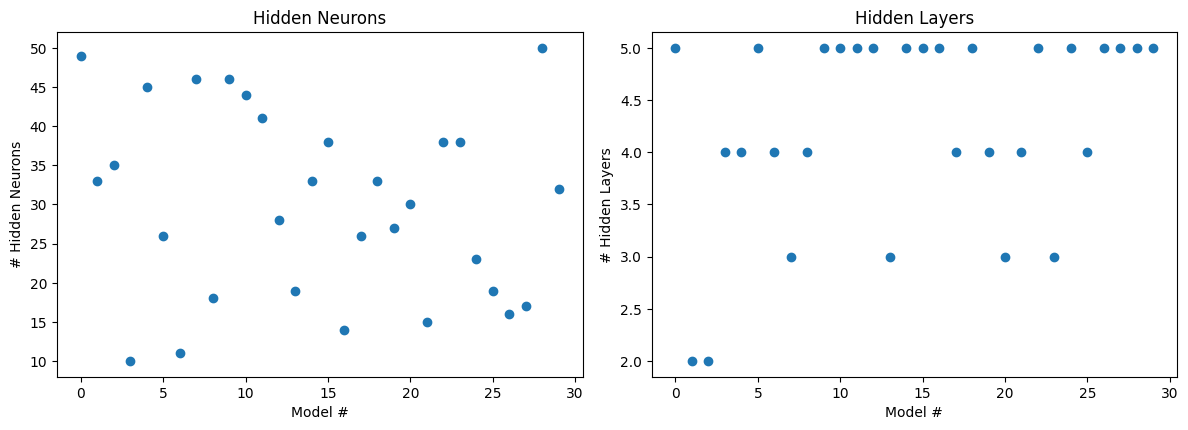

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')
plt.subplot(222)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')
plt.tight_layout()


# plt.figure(figsize=(12,8))
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

# plt.subplot(244)
# plt.scatter(y_val,y_out_ensemble_mean)
# plt.xlabel('y_test')
# plt.ylabel('predicted y')
# #plt.plot((np.min(y_test),np.max(y_test)),'k--')
# # plt.xlabel('y_test')
# # plt.ylabel('y_model')
# # plt.title('Ensemble')
# # plt.subplot(212)
# # plt.plot(y_out_ensemble_mean, label='ensemble mean')
# # plt.plot(np.array(y_val),alpha = 0.5, label='y_true')
plt.tight_layout()

## MLR

In [ ]:

# coding: utf-8
#import all required libraries etc
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import itertools
# In[3]:
#run notebook with functions we'll need
get_ipython().run_line_magic('run', 'Lab2_2023_functions.ipynb')
# In[4]:
#load the data and check it out
data = pd.read_csv('glaciers.csv')
data
# In[5]:
### First, we need to clean the data -- g<=0 is non physical and should be removed.
### Are there any points rows that meet this condition?
np.where(data["g"]<=0)
# In[6]:
### Yes, one row should be removed.
data = data[data["g"]>0].reset_index(drop=True)
### data["g"]>0 generates a series containing "True" and "False" used to index data
### and remove "False" entries
# In[7]:
data # Notice that it is one row shorter!
# In[8]:
#normalize data and check it out
data_norm = (data - data.mean())/data.std()
data_norm
# In[9]:
#visualize normalization
plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
plt.plot(data['g'])
plt.plot(data_norm['g'])
plt.legend(['Raw data','Normalized'])
plt.ylabel('g')
plt.xlabel('glacier')
plt.title('Visualizing Normalization')
plt.subplot(1,2,2)
plt.scatter(data['g'],data_norm['g'])
plt.ylabel('g_norm')
plt.xlabel('g')
plt.title('Visualizing Normalization')
# In[10]:
#unpack normalized data
lat = data_norm['lat']
lon = data_norm['lon']
hmax = data_norm['max_elevation']
hmed = data_norm['median_elevation']
g = data['g'] # response variable does not need to be standardized
Pannual = data_norm['precipitation']
Pwinter = data_norm['winter_precipitation']
CI = data_norm['continentality']
cloud = data_norm['cloud_cover']
Tsummer = data_norm['summer_temperature']
# In[11]:
#target variable: y; predictor variable(s): x
y = g
X = data_norm.drop('g',axis=1)
# # SOLUTIONS:
# # 1) Apply MLR to standardized input
# In[12]:
#make MLR model, fit to the data, and predict y
lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(X,y)
ypred_MLR = lm_MLR.predict(X) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X,y) #R-squared value from MLR model
corr_coef = np.corrcoef(ypred_MLR,y) # Pearson correlation between modeled andtarget y
print('correlation = ' + str(corr_coef[0, 1]))
# In[13]:
#visualize MLR model performance
ax = plt.subplot()
ax.scatter(y,ypred_MLR)
### We want to draw a 1:1 line but don't know the lims to draw it over -- so we query the plot lims,
### Draw a line accordingly and ensure to set the lims
lims = ax.get_xlim()
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims,lims,ls="--", c="grey")
ax.set_xlabel('Measured g')
ax.set_ylabel('Modelled g')
ax.set_title(f'MLR Model Results: R$^2$ = {round(R2_MLR,2)}')
#do MLR using predictors chosen from stepwise regression
lm_step = linear_model.LinearRegression()
model_step = lm_step.fit(X[result],y)
ypred_step = lm_step.predict(X[result]) #y predicted by MLR
intercept_step = lm_step.intercept_ #intercept predicted by MLR
coef_step = lm_step.coef_ #regression coefficients in MLR model
R2_step = lm_step.score(X[result],y) #R-squared value from MLR model
# In[17]:
#visualize stepwise model performance
ax = plt.subplot()
ax.scatter(y,ypred_step)
lims = ax.get_xlim()
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims,lims,ls="--", c="grey")
ax.set_xlabel('Measured g')
ax.set_ylabel('Modelled g')
ax.set_title(f'Stepwise Model Results: R$^2$ = {round(R2_step,2)}')
# Apply calibration - validation approach on standardized input
# In[18]:
#goal: loop through every combination of normalized predictors, make linear model, and find one with best performance
R2_best = []
combo_best = []
for kk in range(1,10): #for each total number of predictors to use in model (from 1predictor to 9 predictors)
v0 = range(np.shape(X)[1])
combinations = list(itertools.combinations(range(np.shape(X)[1]),kk)) #allpossible combinations of kk total predictors
R2_test = []
for ind in range(len(combinations)): #for each combination of predictors, makeMLR model and compute R^2
test_vars = np.array(combinations[ind])
X_test = X.iloc[::2,test_vars] # calibation sample consists of all oddindices in the data
y_test = y.iloc[::2]
X_valid = X.iloc[1::2,test_vars] # validation sample consists of all evenindices in the data
y_valid = y.iloc[1::2]
lm_test = linear_model.LinearRegression()
model_test = lm_test.fit(X_test,y_test)
ypred_test = lm_test.predict(X_test) #y predicted by MLR
R2_test.append(lm_test.score(X_valid,y_valid)) #R-squared value from MLR
model
R2_best.append(np.max(R2_test))
combo_best.append(combinations[np.argmax(R2_test)])
R2_best_final = np.max(R2_best)
combo_best_final = combo_best[np.argmax(R2_best)]
print('The best combination of predictors is: ' )
print(list(X.columns[np.asarray(combo_best_final)]))
# In[19]:
#build linear model using the best combination of predictors
X_calib_valid = X.iloc[:,np.asarray(combo_best_final)]
lm_calib_valid = linear_model.LinearRegression()
model_calib_valid = lm_calib_valid.fit(X_calib_valid,y)
ypred_calib_valid = lm_calib_valid.predict(X_calib_valid) #y predicted by MLR
intercept_calib_valid = lm_calib_valid.intercept_ #intercept predicted by MLR
coef_calib_valid = lm_calib_valid.coef_ #regression coefficients in MLR model
R2_calib_valid = lm_calib_valid.score(X_calib_valid,y) #R-squared value from MLR
model
# In[20]:
#visualize calibration-validation model performance
ax = plt.subplot()
ax.scatter(y,ypred_calib_valid)
lims = ax.get_xlim()
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims,lims,ls="--", c="grey")
ax.set_xlabel('Measured g')
ax.set_ylabel('Modelled g')
ax.set_title(f'Calibration-Validation Model Results: R$^2$ ={round(R2_calib_valid,2)}')
# In[21]:
#Answers to the specific questions:
# 1) How well can the spatial variability in mass balance gradient be represented
# by a multiple linear regression (MLR) using all the plausible predictors from thegiven dataset?
# Answer: R^2 is a metric of the goodness of the fit, which is the same ascorrelation
# coefficient squared. In this case, R^2 = 0.38 (38% variance is expained by theMLR model)
#2) What is the optimal number of predictors in MLR and how much variance in the mass balance gradient
# can be explained by this MLR?
# Answers: According to the stepwise regression there is only one optimal predictor: CI (continentality index)
# With this one predictor, the model explains 25% of the variance (R^2 = 0.25)
# According to the calibration-validation approach optimal number of preditors is4: latitude, max elevation, median elevation, cloud cover
# With this four-predictor model R^2 = 0.32 (32% variance is explained)
# 3) Plot modelled (regressed) mass balance gradients versus observed ones on ascatter plot (with 1:1 line)
# and discuss whether the linear model represents a good fit to the data or not.
# The plots are provided and no obvius outliers are indicated in the scatter plot
# There seems to be a tendency for the model (in all three cases above) to
# underestimate mass balance gradients that are larger then 10 mm w.e. per m
# # Saving figures in python:
# To save figures, use the function plt.savefig()
#
# Vector graphics (.pdf, .eps, etc.) are generally preferable to raster graphics(.jpg, .png) because they are not defined by pixels but instead are defined with aset of "drawing instructions". This means you can scale vector graphics up or downin reports or presentations without a loss of quality. Take a look for yourself:
# In[22]:
ax = plt.subplot()
ax.scatter(y,ypred_calib_valid)
lims = ax.get_xlim()
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims,lims,ls="--", c="grey")
ax.set_xlabel('Measured g')
ax.set_ylabel('Modelled g')
ax.set_title(f'Calibration-Validation Model Results: R$^2$ ={round(R2_calib_valid,2)}')
plt.savefig('testf_pdf.pdf')
plt.savefig('testf_png.png')
# Open the two files and zoom in. You should notice that the .png is pixelated andthe .pdf file is not!
# Generally, vector graphics are preferable. If they're not possible, make sure toincrease the dpi of the png file, e.g.
#
# plt.savefig("testf_png.png",dpi = 400)
#
# All of these options are preferable to taking screenshots!
# In[23]:
print('correlation = ' + str(corr_coef[0, 1]))


## Best performer predictions

### validation subset

In [ ]:
# EVALUATE MODEL OUTPUT
vars = ["gfs_tmin", "gfs_tmax", "us"]
for var in vars:
  test[var] = (test[var] - x_mean) / x_std
  all[var] = (all[var] - x_mean) / x_std
  val[var] = (val[var] - x_mean) / x_std

y_vars = ["tmin_K", "tmax_K"]
for var in y_vars:
  y_train[var] = (y_train[var] - y_mean) / y_std
  test[var] = (test[var] - y_mean) / y_std
  all[var] = (all[var] - y_mean) / y_std
  val[var] = (val[var] - y_mean) / y_std
  print(y_mean)

# VALIDATION
# forecasted TMIN , Corrected TMIN, Actual TMIN
predictions_df = get_predictions_from_best_performer(x_val)
joined_data = join_data_to_original(predictions_df, val)

joined_validation_predictions_filepath = f"{wdir}/validation_data_and_predictions"

joined_data["point_error_tmin"] = joined_data["pred_tmin"] - joined_data["tmin_K"]
joined_data["point_error_tmax"] = joined_data["pred_tmax"] - joined_data["tmax_K"]

joined_data["gfs_error_tmin"] = joined_data["pred_tmin"] - joined_data["gfs_tmin"]
joined_data["gfs_error_tmax"] = joined_data["pred_tmax"] - joined_data["gfs_tmax"]

pickle.dump(joined_data,open(f"{joined_validation_predictions_filepath}.p","wb"))
joined_data.to_csv(f"{joined_validation_predictions_filepath}.csv")



<ipython-input-9-4a07fb6c48a0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all[var] = (all[var] - x_mean) / x_std
<ipython-input-9-4a07fb6c48a0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[var] = (y_train[var] - y_mean) / y_std
<ipython-input-9-4a07fb6c48a0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

260.2766292232225
260.2766292232225
/content/drive/MyDrive/Colab Notebooks/EOSC510_Final/2b1fe551-20b7-45c2-911e-338208fcdd15.p
   pred_tmin  pred_tmax
0  -0.294195  -0.442747
1  -0.157489  -0.333921
2  -0.018235  -0.224372
Index(['pred_tmin', 'pred_tmax'], dtype='object')
2
      Latitude  Longitude    tmin       Date    tmin_K        us    tmax  \
6608     48.71    -122.00 -5.6273 2023-04-15 -2.322553  0.903537  3.0756   
6609     48.71    -121.96 -4.6361 2023-04-15 -2.163295  0.536719  5.3452   
6610     48.71    -121.92 -3.9000 2023-04-15 -2.045024  0.194220  7.4603   

        tmax_K  gfs_lon  gfs_lat  gfs_tmin  gfs_tmax  pred_tmin  pred_tmax  
6608 -0.924240   -122.0    48.75 -1.527883 -1.516967  -0.294195  -0.442747  
6609 -0.559578   -122.0    48.75 -1.527883 -1.516967  -0.157489  -0.333921  
6610 -0.219740   -122.0    48.75 -1.527883 -1.516967  -0.018235  -0.224372  


ValueError: ignored

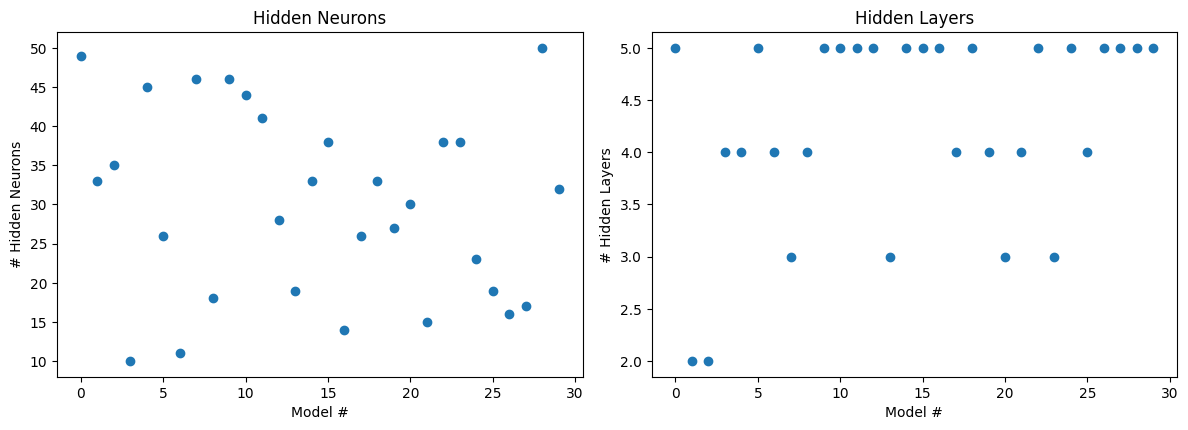

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')
plt.subplot(222)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')
plt.tight_layout()


# plt.figure(figsize=(12,8))
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

# plt.subplot(244)
# plt.scatter(y_val,y_out_ensemble_mean)
# plt.xlabel('y_test')
# plt.ylabel('predicted y')
# #plt.plot((np.min(y_test),np.max(y_test)),'k--')
# # plt.xlabel('y_test')
# # plt.ylabel('y_model')
# # plt.title('Ensemble')
# # plt.subplot(212)
# # plt.plot(y_out_ensemble_mean, label='ensemble mean')
# # plt.plot(np.array(y_val),alpha = 0.5, label='y_true')
plt.tight_layout()

In [ ]:



predictions_df = get_predictions_from_best_performer(x_tst)
joined_data = join_data_to_original(predictions_df, test)

joined_data["point_error_tmin"] = joined_data["pred_tmin"] - joined_data["tmin_K"]
joined_data["point_error_tmax"] = joined_data["pred_tmax"] - joined_data["tmax_K"]

joined_validation_predictions_filepath = f"{wdir}/test_data_and_predictions_all"

pickle.dump(joined_data,open(f"{joined_validation_predictions_filepath}.p","wb"))
joined_data.to_csv(f"{joined_validation_predictions_filepath}.csv")


# all
predictions_df = get_predictions_from_best_performer(x_all)
joined_data = join_data_to_original(predictions_df, all)

joined_data["point_error_tmin"] = joined_data["pred_tmin"] - joined_data["tmin_K"]
joined_data["point_error_tmax"] = joined_data["pred_tmax"] - joined_data["tmax_K"]

joined_validation_predictions_filepath = f"{wdir}/all_data_and_predictions_all"

pickle.dump(joined_data,open(f"{joined_validation_predictions_filepath}.p","wb"))
joined_data.to_csv(f"{joined_validation_predictions_filepath}.csv")



/content/drive/MyDrive/Colab Notebooks/EOSC510_Final/2b1fe551-20b7-45c2-911e-338208fcdd15.p
   pred_tmin  pred_tmax
0   0.205577   0.108232
1   0.115711   0.025037
2   0.180193   0.087364
Index(['pred_tmin', 'pred_tmax'], dtype='object')
2
     Latitude  Longitude    tmin       Date    tmin_K        us    tmax  \
209     48.96    -122.00 -2.5978 2023-04-15 -1.835797 -0.144225  6.9781   
210     48.96    -121.96 -3.4048 2023-04-15 -1.965460  0.206380  5.6880   
211     48.96    -121.92 -3.1109 2023-04-15 -1.918238 -0.048974  7.1849   

       tmax_K  gfs_lon  gfs_lat  gfs_tmin  gfs_tmax  pred_tmin  pred_tmax  
209 -0.297217   -122.0     49.0 -1.525777 -1.511901   0.205577   0.108232  
210 -0.504500   -122.0     49.0 -1.525777 -1.511901   0.115711   0.025037  
211 -0.263990   -122.0     49.0 -1.525777 -1.511901   0.180193   0.087364  
/content/drive/MyDrive/Colab Notebooks/EOSC510_Final/2b1fe551-20b7-45c2-911e-338208fcdd15.p
   pred_tmin  pred_tmax
0   0.205577   0.108232
1   0.115711   

In [ ]:

rmse(predictions_df, y_tst)

pred_tmax    0.0
pred_tmin    0.0
tmax_K       0.0
tmin_K       0.0
dtype: float64

In [ ]:
# tmin_K    0.285505
# tmax_K    0.250797
0.285505 * y_std + y_mean


261.2638188559237

## plots (not in use)

ValueError: ignored

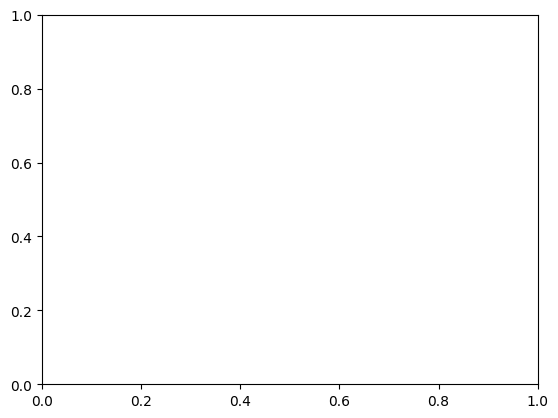

In [ ]:

# ensemble members
plt.plot(x_val.index.tolist(), predicted_output.T,c="k",alpha=0.2)
# ensemble mean
plt.plot(x_val.index.tolist(), predicted_output.mean(axis=0),c="b",label="ensemble mean")
# the thing we are testing
plt.plot(y_val,c="r",label="y test")
plt.xlabel('t')
plt.ylabel('predicted y')
plt.legend()

In [ ]:
# Validation


# Test
predicted_output = np.array([mod.predict(x_test) for mod in loaded_models])
np.savetxt(f"{wdir}/Westland.csv", predicted_output.mean(axis=0), delimiter=",")

Tmin error bigger than tmax -  maybe because GFS is coarse, it doesn't see the mountains. So that would mean it would consistently predict warmer temperatures. This explains why tmax error smaller than tmin error...  




# Overview
  Supervised MLP to bias correct HRRR forecasts over complex terrain.

## Questions:
- Can we improve the forecasts for a single station?
    - input: forecast for station over time series, output: corrected forecast
- Can we improve the TMin/TMax forecasts over stations with heavy orographic effects? (Washington state (cascades, rockies) vs BC (coastal range, rockies) )

## Plan
### Part 1 - single station
1. Start with a single station time series
2. Get a model that bias corrects for that station

### Part 2 - forecast area bias correction
1. Multiple inputs, multiple outputs (lat/lon grid)
2. Use a CNN for this compared to MLP


# Input
  ## Forecasted Tmin Tmax values for a station. (single day)
  ## Forecasted Tmin Tmax values for a station. (spectrum)

# Output

The output is a bias corrected forecast value for TMin, TMax.

# Verification

y_true will be the PRISM observations.


# Methods

MLP with outputs for TMin and TMax

## Validation and training data

Train on Washington stations
Test on Vancouver if possible

One month daily time series across Washington.
Output is time series for one station.